In [1]:
from spinapi import *

print("Copyright (c) 2015 SpinCore Technologies, Inc.");
print("Using SpinAPI Library version %s" % pb_get_version())
print("Found %d boards in the system.\n" % pb_count_boards())

Copyright (c) 2015 SpinCore Technologies, Inc.
Using SpinAPI Library version b'20171214'
Found 0 boards in the system.



In [ ]:
pb_select_board(0)
if pb_init() != 0:
    print("Error initializing board: %s" % pb_get_error())

In [2]:
print(pb_get_version().decode())
print(pb_status_message().decode().strip())
print(pb_get_firmware_id())

20171214
Status error: can't communicate with board.
Try reinstalling SpinAPI.
0


## 1us off/ 2us on

In [ ]:
pb_reset()

pb_core_clock(250.0)
pb_start_programming(PULSE_PROGRAM)
start = pb_inst_pbonly(0x0, CONTINUE, 0, 1 * us)
pb_inst_pbonly(0xFFFFFF, BRANCH , start, 2 * us)
pb_stop_programming()

pb_start()
print(pb_status_message().decode().strip())

## 200ns on / 50ns off

In [ ]:
pb_reset()

pb_core_clock(250.0)
pb_start_programming(PULSE_PROGRAM)
start = pb_inst_pbonly(0xFFFFFF, CONTINUE , 0, 100.0)
pb_inst_pbonly(0xFFFFFF, CONTINUE , 0, 100.0)
pb_inst_pbonly(0x0, BRANCH, start, 50.0)
pb_stop_programming()

pb_start()
print(pb_status_message().decode().strip())

## Using Code Translate An Instruction String

In [3]:
import re
import matplotlib.pyplot as plt
import numpy as np

class PulseSequenceInterpreter:
    def __init__(self, sequence, clock = 250e6):
        self.time_units = {'ns':1, 'us':1e3, 'ms':1e6, 's':1e9}
        self.clock = clock
        
        OFF = int('0b0000 0000 0000 0000 0000 0000'.replace(' ', ''),2)
        ONE_PERIOD = int('0b1000 0000 0000 0000 0000 0000'.replace(' ', ''),2)
        TWO_PERIOD = int('0b0100 0000 0000 0000 0000 0000'.replace(' ', ''),2)
        THREE_PERIOD = int('0b1100 0000 0000 0000 0000 0000'.replace(' ', ''),2)
        FOUR_PERIOD = int('0b0010 0000 0000 0000 0000 0000'.replace(' ', ''),2)
        FIVE_PERIOD = int('0b1010 0000 0000 0000 0000 0000'.replace(' ', ''),2)
        ON = int('0b1110 0000 0000 0000 0000 0000'.replace(' ', ''),2)
        self.fast = [ONE_PERIOD, TWO_PERIOD, THREE_PERIOD, FOUR_PERIOD, FIVE_PERIOD]
        self.on = ON
            
        if isinstance(sequence, str):
            self.addresses, self.sequence = self._string_to_sequence_list(sequence)
            
    def _string_to_sequence_list(self, instructions_string):
        sequence = [seq.replace("\t", "").strip() for seq in instructions_string.rstrip().split("\n")]
        sequence = [seq.split('//')[0] if '//' in seq else seq for seq in sequence]
        sequence = [seq.strip().split(',') for seq in sequence]
        sequence = [seq for seq in sequence if len(seq) != 1]
        sequence_dict = []
        addresses = {}
        for idx, seq in enumerate(sequence):
            seq_dict = {}

            if ':' in seq[0]:
                seq_dict['label'] = seq[0].split(':')[0].strip()
                seq[0] = seq[0].split(':')[-1].strip()
            else:
                seq_dict['label'] = ''

            tmp = int(seq[0].replace(' ', ''), 2) if seq[0][:2] == '0b' else int(seq[0].replace(' ', ''), 16)
            seq_dict['channels'] = channels = [tmp >> i & 1 for i in range(24)]

            t = re.split('([a-zA-Z].*)',seq[1].strip())
            t = list(filter(None, t))
            seq_dict['time'] = int(float(t[0])*self.time_units[t[1]])

            if len(seq) > 2:
                seq_dict['opcode'] = seq[2].strip()
                if len(seq) > 3:
                    seq_dict['instdata'] = seq[3].strip()
                else:
                    seq_dict['instdata'] = ''
            else:
                seq_dict['opcode'] = ''
                seq_dict['instdata'] = ''

            sequence_dict.append(seq_dict)
            if seq_dict['label'] != '':
                addresses[seq_dict['label']] = idx
        
        nested = []
        for idx, seq in enumerate(sequence_dict):
            if seq['opcode'].upper() == 'LOOP':
                nested.append(idx)
            elif seq['opcode'].upper() == 'END_LOOP':
                seq['instdata'] = nested.pop()
                
        return addresses, sequence_dict
    
    def _append_sequence(self, seq, t, c):
        num = sum([1 << c for c,v in enumerate(seq['channels']) if v == 1])
        for idf, f in enumerate(self.fast):
            if (num >> 21) == (f >> 21):
                c.append(seq['channels'])
                c.append(c[0])
                t.append(int(1/self.clock*1e9)*(idf+1))
                t.append(seq['time']-int(1/self.clock*1e9)*(idf+1))
                return
        if (self.on >> 21) == (num >> 21):
            c.append(seq['channels'])
            t.append(seq['time'])
        else:
            c.append([0]*24)
            t.append(seq['time'])
        return

    def generate_pulse_sequence(self):
        c = [[0]*24]
        t = [0]
        
        ids = 0
        nested = []

        while True:
            seq = self.sequence[ids]
            if seq['opcode'].upper() == 'LOOP':
                if (len(nested) == 0) or (nested[-1]['opcode'] != 'LOOP') or (nested[-1]['address'] != ids):  
                    nested.append({'opcode':seq['opcode'], 'address':ids, 'loop_increment':int(seq['instdata'])})
                elif (nested[-1]['opcode'] == 'LOOP') & (nested[-1]['address'] == ids):
                    nested[-1]['loop_increment'] -= 1
                    if nested[-1]['loop_increment'] <= 1:
                        nested.pop()
                ids += 1

            elif seq['opcode'].upper() == 'END_LOOP':
                if len(nested) == 0:
                    ids += 1
                elif nested[-1]['opcode'] == 'LOOP':
                    ids = nested[-1]['address']
                else:
                    ids += 1

            elif seq['opcode'].upper() == 'JSR':
                if seq['instdata'].isdigit():
                    nested.append({'opcode':seq['opcode'], 'address':seq['instdata'], 'return':ids+1})
                else:
                    nested.append({'opcode':seq['opcode'], 'address':self.addresses[seq['instdata']], 'return':ids+1})
                ids = nested[-1]['address']

            elif seq['opcode'].upper() == 'RTS':
                ids = nested[-1]['return']
                nested.pop()

            elif seq['opcode'].upper() == 'BRANCH':
                self._append_sequence(seq, t, c)
                break

            elif seq['opcode'].upper() == 'STOP':
                self._append_sequence(seq, t, c)
                break

            elif seq['opcode'].upper() == 'LONG_DELAY':
                t.append(int(seq['instdata'])*seq['time'])
                num = sum([1 << c for c,v in enumerate(seq['channels']) if v == 1])
                if (num >> 21) == (self.on >> 21):
                    c.append(seq['channels'])
                else:
                    c.append([0]*24)
                ids += 1
                continue
            else:
                ids += 1
                if ids >= len(self.sequence):
                    break
            self._append_sequence(seq, t, c)
        return np.array(t),np.array(c)
    
    def plot_pulse_sequence(self, channels = None):
        t,c = self.generate_pulse_sequence()
        tcum = np.cumsum(np.array(t)/1e9)
        c = np.array(c)[:,:21]
        select = np.where(np.sum(c, axis = 0) != 0)[0]
        c = c[:,select]
        if isinstance(channels, type(None)) or (len(channels) != len(select)):
            channels = ['CH '+str(i) for i in select]
        fig, ax = plt.subplots(figsize = (18,18/21*len(select)))
        for ids, s in enumerate(c.T):
            ax.step(tcum,s+1.3*ids, lw = 3)
        ax.get_yaxis().set_ticks([])
        ax.legend(channels, fontsize = 15)
        ax.set_xlabel('time [s]', fontsize = 15)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=12)
        ax.xaxis.get_offset_text().set_size(15)

In [4]:
from spinapi import *

class PulseSequenceProgrammer:
    def __init__(self, board_number, sequence, addresses, clock = 250e6):
        self.board_number = board_number
        self.clock = clock
        self.sequence = sequence
        self.addresses = addresses
    
    def program_device(self, board_number = None):
        
        if type(board_number) == None:
            board_number = self.board_number
            
        addresses = self.addresses
        sequence = self.sequence
        
        pb_reset()

        pb_core_clock(int(self.clock/1e6))
        pb_start_programming(PULSE_PROGRAM)
        try:
            for seq in sequence:
                opcode = seq['opcode']
                instdata = seq['instdata']
                duration = seq['time']
                channels = seq['channels']
                channels = np.sum([i*2**idx for idx, i in enumerate(channels)])
                if opcode.upper() == 'JSR':
                    try:
                        pb_inst_pbonly(channels, JSR, addresses[instdata], duration*ns)
                    except KeyError:
                        pb_inst_pbonly(channels, JSR, instdata, duration*ns)
                elif opcode.upper() == 'RTS':
                    pb_inst_pbonly(channels, RTS, 0, duration*ns)
                elif opcode.upper() == 'BRANCH':
                    try:
                        pb_inst_pbonly(channels, BRANCH, addresses[instdata], duration*ns)
                    except KeyError:
                        pb_inst_pbonly(channels, BRANCH, instdata, duration*ns)
                elif opcode.upper() == 'LOOP':
                    pb_inst_pbonly(channels, LOOP, eval(instdata), duration*ns)
                elif opcode.upper() == 'END_LOOP':
                    try:
                        pb_inst_pbonly(channels, END_LOOP, addresses[instdata], duration*ns)
                    except KeyError:
                        pb_inst_pbonly(channels, END_LOOP, instdata, duration*ns)
                elif opcode.upper() == 'LONG_DELAY':
                    pb_inst_pbonly(channels, LONG_DELAY, eval(instdata), duration*ns)
                else:
                    if opcode == '':
                        opcode = '0'
                    pb_inst_pbonly(channels, eval(opcode), 0, duration*ns)
        except Exception as e:
            print(seq)
            raise e
        pb_stop_programming()

In [ ]:
sequence = """// Sample program for SpinCore PulseBlaster Interpreter.
// Simple all on all off pattern.

label: 0b1111 1111 1111 1111 1111 1111, 10 ms // All bits on for 500 ms, Continue to next instruction
       0b0000 0000 0000 0000 0000 0000, 10 ms, branch, label // All bits off for 500 ms, branch to label
"""
interpreter = PulseSequenceInterpreter(sequence)
t,c = interpreter.generate_pulse_sequence()
interpreter.plot_pulse_sequence()

programmer = PulseSequenceProgrammer(0, interpreter.sequence, interpreter.addresses)
programmer.program_device()
pb_start()

In [ ]:
sequence = """// Sample program for SpinCore PulseBlaster Interpreter.
// SOS using sub routines.
       0x000000, 50ms, CONTINUE
start: 0x000000, 1ms, JSR, short
       0x000000, 1ms, JSR, long
       0x000000, 1ms, JSR, short
       0x000000, 50ms, BRANCH, start

// 3 Short			
short: 0xFFFFFF, 10ms
       0x000000, 10ms
       0xFFFFFF, 10ms
       0x000000, 10ms
       0xFFFFFF, 10ms
       0x000000, 10ms, RTS
			
// 3 Long
long:  0xFFFFFF, 30ms
       0x000000, 10ms
       0xFFFFFF, 30ms
       0x000000, 10ms
       0xFFFFFF, 30ms
       0x000000, 10ms, RTS
"""
interpreter = PulseSequenceInterpreter(sequence)
t,c = interpreter.generate_pulse_sequence()
interpreter.plot_pulse_sequence()

programmer = PulseSequenceProgrammer(0, interpreter.sequence, interpreter.addresses)
programmer.program_device()
pb_start()

In [ ]:
sequence =  """// Sample program for SpinCore PulseBlaster Interpreter.
// SOS using loops.

// 3 Short			
       0x000000, 500ms, CONTINUE
start: 0xFFFFFF, 100ms, LOOP, 3
       0x000000, 100ms, END_LOOP
			
// 3 Long
       0xFFFFFF, 300ms, LOOP, 3
       0x000000, 100ms, END_LOOP
			
// 3 Short			
       0xFFFFFF, 100ms, LOOP, 3
       0x000000, 100ms, END_LOOP
			
// A pause
       0x000000, 500ms, branch, start // branch to start
"""

interpreter = PulseSequenceInterpreter(sequence)
t,c = interpreter.generate_pulse_sequence()
interpreter.plot_pulse_sequence()

programmer = PulseSequenceProgrammer(0, interpreter.sequence, interpreter.addresses)
programmer.program_device()
pb_start()

In [ ]:
sequence = """// 
start: 0b1110 0000 0000 0000 0000 1111, 50 ns // All bits on for 50 ns, Continue to next instruction
       0b1010 0000 0000 0000 0000 0101, 50 ns // 5 clock cycle pulse on channel 0 only
       0b0000 0000 0000 0000 0000 0000, 50 ns, branch, start
"""
interpreter = PulseSequenceInterpreter(sequence)
t,c = interpreter.generate_pulse_sequence()
interpreter.plot_pulse_sequence()

programmer = PulseSequenceProgrammer(0, interpreter.sequence, interpreter.addresses)
programmer.program_device()
pb_start()

## Setting Up Easier Pulse Generation

In [ ]:
def generate_repeating_pulse(channels, frequency, duty_cycle, toffset, duration):
    nr_20ns_cycles = int(duration/(20))
    offset = int(toffset / 20)
    c = [[0]*24 for _ in range(nr_20ns_cycles)]
    t = np.array([20]*nr_20ns_cycles)
    dut = int(duty_cycle / 20)
    f = int(1/frequency / 20e-9)
    
    ctemp = [0]*24
    ctemp[-3:] = [1,1,1]
    for chan in channels:
        ctemp[chan] = 1
    
    idf = 0
    for idx in range(offset, nr_20ns_cycles):
        if idf < dut:
            c[idx] = ctemp
        idf += 1
        if idf % f == 0:
            idf = 0
    return t, c

In [ ]:
t, c = generate_repeating_pulse([0,1], 1e5, 1000, 1000, 210000)
t1, c1 = generate_repeating_pulse([2], 1e5/5, 1000, 2500, 210000)
for idr, chs1 in enumerate(c1):
    for idc, ch1 in enumerate(chs1):
        if ch1:
            c[idr][idc] = 1

In [ ]:
tcum = np.cumsum(np.array(t)/1e9)
c = np.array(c)[:,:21]
select = np.where(np.sum(c, axis = 0) != 0)[0]
c = c[:,select]
channels = None
if isinstance(channels, type(None)) or (len(channels) != len(select)):
    channels = ['CH '+str(i) for i in select]
fig, ax = plt.subplots(figsize = (18,18/21*len(select)))
for ids, s in enumerate(c.T):
    ax.step(tcum,s+1.3*ids, lw = 3)
ax.get_yaxis().set_ticks([])
ax.legend(channels, fontsize = 15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_size(15)

## Method without generating a new instruction for every 20ns

In [ ]:
from functools import reduce 
def gcd(a, b):
    """Return greatest common divisor using Euclid's Algorithm."""
    while b:      
        a, b = b, a % b
    return a

def gcdm(*args):
    """Return gcm of args"""
    return reduce(gcd, args)

def generate_repeating_pulses(pulses, duration):
    c = []
    t = []
    
    min_instruction_len = 20 # minimum instruction length in ns
    nr_cycles = int(duration/min_instruction_len)
    
    # calculating the offset, frequency and amount of time at high state
    # in units of minimum_instruction_len
    pulses_cycle_units = []
    instruction_cycles = []
    for pulse in pulses:
        f = int(1/pulse['frequency'] / (min_instruction_len*1e-9))
        o = int(pulse['offset'] / min_instruction_len)
        h = int(pulse['high'] / min_instruction_len)
        instruction_cycles.append(f)
        instruction_cycles.append(h)
        if o != 0:
            instruction_cycles.append(o)
        pulses_cycle_units.append({'frequency':f, 'offset':o, 'high':h, 'channels':pulse['channels']})        
    
    # checking whether the minimum clock cycles instruction length can be increased
    # by checking for the greatest common denominator to speed up sequence generation
    if instruction_cycles:
        instruction_cycles.append(nr_cycles)
    gcd_cycles = gcdm(*instruction_cycles)
    if gcd_cycles != 1:
        for pulse in pulses_cycle_units:
            pulse['frequency'] //= gcd_cycles
            pulse['offset'] //= gcd_cycles
            pulse['high'] //= gcd_cycles
            
    min_instruction_len *= gcd_cycles
    nr_cycles = int(duration/min_instruction_len)
    
    # generating the pulseblaster instructions
    idx_reset_pulse = [0]*len(pulses)
                    
    for idx in range(nr_cycles):
        channels_active = []
        for idx_pulse, pulse in enumerate(pulses_cycle_units):
            if idx >= pulse['offset']:
                if idx_reset_pulse[idx_pulse] < pulse['high']:
                    [channels_active.append(ch) for ch in pulse['channels']]
                idx_reset_pulse[idx_pulse] += 1
                idx_reset_pulse[idx_pulse] = idx_reset_pulse[idx_pulse] % pulse['frequency']
                
        if channels_active:
            chs = [0]*24
            chs[-3:] = [1,1,1]
            for idx in np.unique(channels_active):
                chs[idx] = 1
            if not c:
                t.append(min_instruction_len)
                c.append(chs)
            else:
                if c[-1] == chs:
                    t[-1] += min_instruction_len
                else:
                    t.append(min_instruction_len)
                    c.append(chs)
        else:
            if not c:
                c.append([0]*24)
                t.append(min_instruction_len)
            else:
                if c[-1] == [0]*24:
                    t[-1] += min_instruction_len
                else:
                    c.append([0]*24)
                    t.append(min_instruction_len)
    
    pulse_sequence = []
    for t_, c_ in zip(t,c):
        s = {'label': '', 'channels': c_, 'time': t_, 'opcode': 'CONTINUE', 'instdata': 0}
        pulse_sequence.append(s)

    t = [0]+t
    c = [[0]*24]+c
    
    return t, c, pulse_sequence

In [ ]:
pulse1 = {'frequency':1e5, 'offset':0, 'high': 1000, 'channels':[0]}
pulse2 = {'frequency':1e5, 'offset':1500, 'high': 2000, 'channels':[1]}
t, c, sequence = generate_repeating_pulses([pulse1, pulse2], 20000)
sequence.append({'label':'', 'channels':[0]*24, 'time':10000, 'opcode':'BRANCH', 'instdata':0})

programmer = PulseSequenceProgrammer(0, sequence, {})
programmer.program_device()
pb_start()

for s in sequence:
    print(s)

In [ ]:
tcum = np.cumsum(np.array(t)/1e9)
c = np.array(c)[:,:21]
select = np.where(np.sum(c, axis = 0) != 0)[0]
c = c[:,select]
channels = None
if isinstance(channels, type(None)) or (len(channels) != len(select)):
    channels = ['CH '+str(i) for i in select]
fig, ax = plt.subplots(figsize = (18,18/21*len(select)))
for ids, s in enumerate(c.T):
    ax.step(tcum,s+1.3*ids, lw = 3)
ax.get_yaxis().set_ticks([])
ax.legend(channels, fontsize = 15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_size(15)

In [ ]:
pulse1 = {'frequency':1e5, 'offset':1000, 'high': 1000, 'channels':[0]}
pulse2 = {'frequency':1e5, 'offset':1000, 'high': 2000, 'channels':[1]}
pulse3 = {'frequency':1e5/5, 'offset':2500, 'high':1000, 'channels':[2]}
pulse4 = {'frequency':1e5/5/2, 'offset':4000, 'high':1000, 'channels':[3,4]}
t, c, sequence = generate_repeating_pulses([pulse1, pulse2, pulse3, pulse4], 10000)
sequence.append({'label':'', 'channels':[0]*24, 'time':10000, 'opcode':'BRANCH', 'instdata':0})

programmer = PulseSequenceProgrammer(0, sequence, {})
programmer.program_device()
pb_start()

In [ ]:
tcum = np.cumsum(np.array(t)/1e9)
c = np.array(c)[:,:21]
select = np.where(np.sum(c, axis = 0) != 0)[0]
c = c[:,select]
channels = None
if isinstance(channels, type(None)) or (len(channels) != len(select)):
    channels = ['CH '+str(i) for i in select]
fig, ax = plt.subplots(figsize = (18,18/21*len(select)))
for ids, s in enumerate(c.T):
    ax.step(tcum,s+1.3*ids, lw = 3)
ax.get_yaxis().set_ticks([])
ax.legend(channels, fontsize = 15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_size(15)

In [ ]:
factor = 10
pulse_flashlamp = {'frequency':10*factor, 'offset':0, 'high': 400e4, 'channels':[0]}
pulse_qswitch = {'frequency':5*factor, 'offset':200e3, 'high':400e4, 'channels':[1]}
t, c, sequence = generate_repeating_pulses([pulse_flashlamp, pulse_qswitch], 0.4*1e9/factor-1e5)
sequence.append({'label':'', 'channels':[0]*24, 'time':1e5, 'opcode':'BRANCH', 'instdata':0})

programmer = PulseSequenceProgrammer(0, sequence, {})
programmer.program_device()
pb_start()

In [ ]:
tcum = np.cumsum(np.array(t)/1e9)
c = np.array(c)[:,:21]
select = np.where(np.sum(c, axis = 0) != 0)[0]
c = c[:,select]
channels = None
if isinstance(channels, type(None)) or (len(channels) != len(select)):
    channels = ['CH '+str(i) for i in select]
fig, ax = plt.subplots(figsize = (18,18/21*len(select)))
for ids, s in enumerate(c.T):
    ax.step(tcum,s+1.3*ids, lw = 3)
ax.get_yaxis().set_ticks([])
ax.legend(channels, fontsize = 15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_size(15)

In [ ]:
pulse1 = {'frequency':1e5, 'offset':0, 'high': 1000, 'channels':[0]}
pulse2 = {'frequency':1e5/2, 'offset':1000, 'high':1000, 'channels':[1]}
t, c, sequence = generate_repeating_pulses([pulse1, pulse2], 2e4-1e3)
sequence.append({'label':'', 'channels':[0]*24, 'time':1e3, 'opcode':'BRANCH', 'instdata':0})

programmer = PulseSequenceProgrammer(0, sequence, {})
programmer.program_device()
pb_start()

In [ ]:
tcum = np.cumsum(np.array(t)/1e9)
c = np.array(c)[:,:21]
select = np.where(np.sum(c, axis = 0) != 0)[0]
c = c[:,select]
channels = None
if isinstance(channels, type(None)) or (len(channels) != len(select)):
    channels = ['CH '+str(i) for i in select]
fig, ax = plt.subplots(figsize = (18,18/21*len(select)))
for ids, s in enumerate(c.T):
    ax.step(tcum,s+1.3*ids, lw = 3)
ax.get_yaxis().set_ticks([])
ax.legend(channels, fontsize = 15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_size(15)

In [ ]:
pulse1 = {'frequency':1e5, 'offset':0, 'high': 1000, 'channels':[0]}
pulse2 = {'frequency':1e5/4, 'offset':1000, 'high':1000, 'channels':[1]}
t, c, sequence = generate_repeating_pulses([pulse1, pulse2], 4e4-1e3)
sequence.append({'label':'', 'channels':[0]*24, 'time':int(1e3), 'opcode':'BRANCH', 'instdata':0})

programmer = PulseSequenceProgrammer(0, sequence, {})
programmer.program_device()
pb_start()

for s in sequence:
    print(s)

In [ ]:
tcum = np.cumsum(np.array(t)/1e9)
c = np.array(c)[:,:21]
select = np.where(np.sum(c, axis = 0) != 0)[0]
c = c[:,select]
channels = None
if isinstance(channels, type(None)) or (len(channels) != len(select)):
    channels = ['CH '+str(i) for i in select]
fig, ax = plt.subplots(figsize = (18,18/21*len(select)))
for ids, s in enumerate(c.T):
    ax.step(tcum,s+1.3*ids, lw = 3)
ax.get_yaxis().set_ticks([])
ax.legend(channels, fontsize = 15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_size(15)

In [ ]:
from functools import reduce 
def gcd(a, b):
    """Return greatest common divisor using Euclid's Algorithm."""
    while b:      
        a, b = b, a % b
    return a

def gcdm(*args):
    """Return gcm of args"""
    return reduce(gcd, args)

def generate_repeating_pulses(pulses):
    c = []
    t = []
    
    min_instruction_len = 20 # minimum instruction length in ns
    
    # calculating the minimum duration required to perform all pulses
    duration = int(round(max([1/p['frequency'] for p in pulses])/1e-9,2))
    nr_cycles = int(duration/min_instruction_len)
        
    # calculating the offset, frequency and amount of time at high state
    # in units of minimum_instruction_len
    pulses_cycle_units = []
    instruction_cycles = []
    for pulse in pulses:
        f = int(1/pulse['frequency'] / (min_instruction_len*1e-9))
        o = int(pulse['offset'] / min_instruction_len)
        h = int(pulse['high'] / min_instruction_len)
        instruction_cycles.append(f)
        instruction_cycles.append(h)
        if o != 0:
            instruction_cycles.append(o)
        pulses_cycle_units.append({'frequency':f, 'offset':o, 'high':h, 'channels':pulse['channels']})        
    
        
    
    # checking whether the minimum clock cycles instruction length can be increased
    # by checking for the greatest common denominator to speed up sequence generation
    if instruction_cycles:
        instruction_cycles.append(nr_cycles)
    gcd_cycles = gcdm(*instruction_cycles)
    if gcd_cycles != 1:
        for pulse in pulses_cycle_units:
            pulse['frequency'] //= gcd_cycles
            pulse['offset'] //= gcd_cycles
            pulse['high'] //= gcd_cycles
            
    min_instruction_len *= gcd_cycles
    nr_cycles = int(duration/min_instruction_len)-1
    
    print('minimum instruction cycles : {0}'.format(min_instruction_len))
    
    # generating the pulseblaster instructions
    idx_reset_pulse = [0]*len(pulses)
                    
    for idx in range(nr_cycles):
        channels_active = []
        for idx_pulse, pulse in enumerate(pulses_cycle_units):
            if idx >= pulse['offset']:
                if idx_reset_pulse[idx_pulse] < pulse['high']:
                    [channels_active.append(ch) for ch in pulse['channels']]
                idx_reset_pulse[idx_pulse] += 1
                idx_reset_pulse[idx_pulse] = idx_reset_pulse[idx_pulse] % pulse['frequency']
                
        if channels_active:
            chs = [0]*24
            chs[-3:] = [1,1,1]
            for idx in np.unique(channels_active):
                chs[idx] = 1
            if not c:
                t.append(min_instruction_len)
                c.append(chs)
            else:
                if c[-1] == chs:
                    t[-1] += min_instruction_len
                else:
                    t.append(min_instruction_len)
                    c.append(chs)
        else:
            if not c:
                c.append([0]*24)
                t.append(min_instruction_len)
            else:
                if c[-1] == [0]*24:
                    t[-1] += min_instruction_len
                else:
                    c.append([0]*24)
                    t.append(min_instruction_len)
    
    pulse_sequence = []
    for t_, c_ in zip(t,c):
        s = {'label': '', 'channels': c_, 'time': t_, 'opcode': 'CONTINUE', 'instdata': 0}
        pulse_sequence.append(s)
    pulse_sequence.append({'label':'', 'channels':[0]*24, 'time':min_instruction_len, 'opcode':'BRANCH', 'instdata':0})

    t = [0]+t
    c = [[0]*24]+c
    t.append(min_instruction_len)
    c.append([0]*24)
    
    return t, c, pulse_sequence

In [ ]:
pulse1 = {'frequency':1e5, 'offset':0, 'high': 1000, 'channels':[0]}
pulse2 = {'frequency':1e5/4, 'offset':1000, 'high':1000, 'channels':[1]}
t, c, sequence = generate_repeating_pulses([pulse1, pulse2])

programmer = PulseSequenceProgrammer(0, sequence, {})
programmer.program_device()
pb_start()

for s in sequence:
    print(s)
    
tcum = np.cumsum(np.array(t)/1e9)
c = np.array(c)[:,:21]
select = np.where(np.sum(c, axis = 0) != 0)[0]
c = c[:,select]
channels = None
if isinstance(channels, type(None)) or (len(channels) != len(select)):
    channels = ['CH '+str(i) for i in select]
fig, ax = plt.subplots(figsize = (18,18/21*len(select)))
for ids, s in enumerate(c.T):
    ax.step(tcum,s+1.3*ids, lw = 3)
ax.get_yaxis().set_ticks([])
ax.legend(channels, fontsize = 15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_size(15)

In [ ]:
pulse1 = {'frequency':50, 'offset':0, 'high': int(10e-3/1e-9), 'channels':[0]}
pulse2 = {'frequency':10, 'offset':int(215e-6/1e-9), 'high':int(10e-3/1e-9), 'channels':[1]}
t, c, sequence = generate_repeating_pulses([pulse1, pulse2])

programmer = PulseSequenceProgrammer(0, sequence, {})
programmer.program_device()
pb_start()

for s in sequence:
    print(s)
    
tcum = np.cumsum(np.array(t)/1e9)
c = np.array(c)[:,:21]
select = np.where(np.sum(c, axis = 0) != 0)[0]
c = c[:,select]
channels = None
if isinstance(channels, type(None)) or (len(channels) != len(select)):
    channels = ['CH '+str(i) for i in select]
fig, ax = plt.subplots(figsize = (18,18/21*len(select)))
for ids, s in enumerate(c.T):
    ax.step(tcum,s+1.3*ids, lw = 3)
ax.get_yaxis().set_ticks([])
ax.legend(channels, fontsize = 15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_size(15)

In [ ]:
trigger = {'frequency':5, 'offset':0, 'high': int(round(10e-3/1e-9,2)), 'channels':[0]}
flashlamp = {'frequency':50, 'offset':int(round(2e-3/1e-9,2)), 'high': int(round(10e-3/1e-9,2)), 'channels':[1]}
qswitch = {'frequency':5, 'offset':int(round(2e-3/1e-9,2))+int(round(215e-6/1e-9,2)), 'high':int(round(10e-3/1e-9,2)), 'channels':[2]}
t, c, sequence = generate_repeating_pulses([trigger, flashlamp, qswitch])

programmer = PulseSequenceProgrammer(0, sequence, {})
programmer.program_device()
pb_start()

for s in sequence:
    print(s)
    
tcum = np.cumsum(np.array(t)/1e9)
c = np.array(c)[:,:21]
select = np.where(np.sum(c, axis = 0) != 0)[0]
c = c[:,select]
channels = None
if isinstance(channels, type(None)) or (len(channels) != len(select)):
    channels = ['CH '+str(i) for i in select]
fig, ax = plt.subplots(figsize = (18,18/21*len(select)))
for ids, s in enumerate(c.T):
    ax.step(tcum,s+1.3*ids, lw = 3)
ax.get_yaxis().set_ticks([])
ax.legend(channels, fontsize = 15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_size(15)

In [ ]:
from functools import reduce 
def gcd(a, b):
    """Return greatest common divisor using Euclid's Algorithm."""
    while b:      
        a, b = b, a % b
    return a

def gcdm(*args):
    """Return gcm of args"""
    return reduce(gcd, args)

def generate_repeating_pulses(pulses, duration = None):
    c = []
    t = []
    
    min_instruction_len = 20 # minimum instruction length in ns
    
    # calculating the minimum duration required to perform all pulses
    if type(duration) == type(None):
        duration = int(round(max([1/p['frequency'] for p in pulses])/1e-9,2))
    nr_cycles = int(duration/min_instruction_len)
        
    # calculating the offset, frequency and amount of time at high state
    # in units of minimum_instruction_len
    pulses_cycle_units = []
    instruction_cycles = []
    for pulse in pulses:
        f = int(1/pulse['frequency'] / (min_instruction_len*1e-9))
        o = int(pulse['offset'] / min_instruction_len)
        h = int(pulse['high'] / min_instruction_len)
        instruction_cycles.append(f)
        instruction_cycles.append(h)
        if o != 0:
            instruction_cycles.append(o)
        pulses_cycle_units.append({'frequency':f, 'offset':o, 'high':h, 'channels':pulse['channels']})        
    
        
    
    # checking whether the minimum clock cycles instruction length can be increased
    # by checking for the greatest common denominator to speed up sequence generation
    if instruction_cycles:
        instruction_cycles.append(nr_cycles)
    gcd_cycles = gcdm(*instruction_cycles)
    if gcd_cycles != 1:
        for pulse in pulses_cycle_units:
            pulse['frequency'] //= gcd_cycles
            pulse['offset'] //= gcd_cycles
            pulse['high'] //= gcd_cycles
            
    min_instruction_len *= gcd_cycles
    nr_cycles = int(duration/min_instruction_len)-1
    
    print('minimum instruction cycles : {0}'.format(min_instruction_len))
    
    # generating the pulseblaster instructions
    idx_reset_pulse = [0]*len(pulses)
                    
    for idx in range(nr_cycles):
        channels_active = []
        for idx_pulse, pulse in enumerate(pulses_cycle_units):
            if idx >= pulse['offset']:
                if idx_reset_pulse[idx_pulse] < pulse['high']:
                    [channels_active.append(ch) for ch in pulse['channels']]
                idx_reset_pulse[idx_pulse] += 1
                idx_reset_pulse[idx_pulse] = idx_reset_pulse[idx_pulse] % pulse['frequency']
                
        if channels_active:
            chs = [0]*24
            chs[-3:] = [1,1,1]
            for idx in np.unique(channels_active):
                chs[idx] = 1
            if not c:
                t.append(min_instruction_len)
                c.append(chs)
            else:
                if c[-1] == chs:
                    t[-1] += min_instruction_len
                else:
                    t.append(min_instruction_len)
                    c.append(chs)
        else:
            if not c:
                c.append([0]*24)
                t.append(min_instruction_len)
            else:
                if c[-1] == [0]*24:
                    t[-1] += min_instruction_len
                else:
                    c.append([0]*24)
                    t.append(min_instruction_len)
    
    pulse_sequence = []
    for t_, c_ in zip(t,c):
        s = {'label': '', 'channels': c_, 'time': t_, 'opcode': 'CONTINUE', 'instdata': 0}
        pulse_sequence.append(s)
    pulse_sequence.append({'label':'', 'channels':[0]*24, 'time':min_instruction_len, 'opcode':'BRANCH', 'instdata':0})

    t = [0]+t
    c = [[0]*24]+c
    t.append(min_instruction_len)
    c.append([0]*24)
    
    return t, c, pulse_sequence

In [ ]:
trigger = {'frequency':5, 'offset':0, 'high': int(round(10e-3/1e-9,2)), 'channels':[0]}
flashlamp = {'frequency':50, 'offset':int(round(2e-3/1e-9,2)), 'high': int(round(10e-3/1e-9,2)), 'channels':[1]}
qswitch = {'frequency':5, 'offset':int(round(2e-3/1e-9,2))+int(round(215e-6/1e-9,2)), 'high':int(round(10e-3/1e-9,2)), 'channels':[2]}
t, c, sequence = generate_repeating_pulses([trigger, flashlamp, qswitch])

programmer = PulseSequenceProgrammer(0, sequence, {})
programmer.program_device()
pb_start()

for s in sequence:
    print(s)
    
tcum = np.cumsum(np.array(t)/1e9)
c = np.array(c)[:,:21]
select = np.where(np.sum(c, axis = 0) != 0)[0]
c = c[:,select]
channels = None
if isinstance(channels, type(None)) or (len(channels) != len(select)):
    channels = ['CH '+str(i) for i in select]
fig, ax = plt.subplots(figsize = (18,18/21*len(select)))
for ids, s in enumerate(c.T):
    ax.step(tcum,s+1.3*ids, lw = 3)
ax.get_yaxis().set_ticks([])
ax.legend(channels, fontsize = 15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_size(15)

## Adding active high or low functionality

In [ ]:
from functools import reduce 
def gcd(a, b):
    """Return greatest common divisor using Euclid's Algorithm."""
    while b:      
        a, b = b, a % b
    return a

def gcdm(*args):
    """Return gcm of args"""
    return reduce(gcd, args)

def all_channels_off(pulses):
    c = [0]*24
    for pulse in pulses:
        if not pulse['active_high']:
            for ch in pulse['channels']:
                c[ch] = 1
            c[-3:] = [1,1,1]
    return c

def generate_repeating_pulses(pulses, duration = None):
    c = []
    t = []
    
    min_instruction_len = 20 # minimum instruction length in ns
    
    # calculating the minimum duration required to perform all pulses
    if type(duration) == type(None):
        duration = int(round(max([1/p['frequency'] for p in pulses])/1e-9,2))
    nr_cycles = int(duration/min_instruction_len)
        
    # calculating the offset, frequency and amount of time at high state
    # in units of minimum_instruction_len
    pulses_cycle_units = []
    instruction_cycles = []
    for pulse in pulses:
        f = int(1/pulse['frequency'] / (min_instruction_len*1e-9))
        o = int(pulse['offset'] / min_instruction_len)
        h = int(pulse['high'] / min_instruction_len)
        instruction_cycles.append(f)
        instruction_cycles.append(h)
        if o != 0:
            instruction_cycles.append(o)
        pulses_cycle_units.append({'frequency':f, 'offset':o, 'high':h, 'channels':pulse['channels'], 
                                   'active_high':pulse['active_high']})        
    
        
    
    # checking whether the minimum clock cycles instruction length can be increased
    # by checking for the greatest common denominator to speed up sequence generation
    if instruction_cycles:
        instruction_cycles.append(nr_cycles)
    gcd_cycles = gcdm(*instruction_cycles)
    if gcd_cycles != 1:
        for pulse in pulses_cycle_units:
            pulse['frequency'] //= gcd_cycles
            pulse['offset'] //= gcd_cycles
            pulse['high'] //= gcd_cycles
            
    min_instruction_len *= gcd_cycles
    nr_cycles = int(duration/min_instruction_len)-1
    
    print('minimum instruction cycles : {0}'.format(min_instruction_len))
    
    # generating the pulseblaster instructions
    idx_reset_pulse = [0]*len(pulses)
        
    for idx in range(nr_cycles):
        channels_active = []
        for idx_pulse, pulse in enumerate(pulses_cycle_units):
            if idx >= pulse['offset']:
                if idx_reset_pulse[idx_pulse] < pulse['high']:
                    [channels_active.append(ch) for ch in pulse['channels']]
                idx_reset_pulse[idx_pulse] += 1
                idx_reset_pulse[idx_pulse] = idx_reset_pulse[idx_pulse] % pulse['frequency']
        
        if channels_active:
            chs = [0]*24
            chs[-3:] = [1,1,1]
            for idx in channels_active:
                chs[idx] = 1
            if not c:
                t.append(min_instruction_len)
                c.append(chs)
            else:
                if c[-1] == chs:
                    t[-1] += min_instruction_len
                else:
                    t.append(min_instruction_len)
                    c.append(chs)
        else:
            if not c:
                c.append([0]*24)
                t.append(min_instruction_len)
            else:
                if c[-1] == [0]*24:
                    t[-1] += min_instruction_len
                else:
                    c.append([0]*24)
                    t.append(min_instruction_len)
    
    channels_inverted = [p for pulse in pulses for p in pulse['channels'] if not pulse['active_high']]
    channels_off = all_channels_off(pulses)
    for c_ in c:
        for ch_inv in channels_inverted:
            if c_[ch_inv]:
                c_[ch_inv] = 0
                if c_[:20] == [0]*20:
                    c_[-3:] = [0,0,0]
            else:
                if c_ == [0]*24:
                    c_[-3:] = [1,1,1]
                c_[ch_inv] = 1
    
    pulse_sequence = []
    for t_, c_ in zip(t,c):
        s = {'label': '', 'channels': c_, 'time': t_, 'opcode': 'CONTINUE', 'instdata': 0}
        pulse_sequence.append(s)
    pulse_sequence.append({'label':'', 'channels':channels_off.copy(), 'time':min_instruction_len, 'opcode':'BRANCH', 'instdata':0})

    t = [0]+t
    c = [channels_off]+c
    t.append(min_instruction_len)
    c.append(channels_off)
    
    return t, c, pulse_sequence

In [ ]:
trigger = {'frequency':10, 'offset':0, 'high': int(round(10e-3/1e-9,2)), 'channels':[0], 'active_high':False}
flashlamp = {'frequency':50, 'offset':int(round(2e-3/1e-9,2)), 'high': int(round(10e-3/1e-9,2)), 'channels':[1], 'active_high':True}
qswitch = {'frequency':10, 'offset':int(round(2e-3/1e-9,2))+int(round(215e-6/1e-9,2)), 'high':int(round(10e-3/1e-9,2)), 'channels':[2], 'active_high':True}
t, c, sequence = generate_repeating_pulses([trigger, flashlamp, qswitch])

programmer = PulseSequenceProgrammer(0, sequence, {})
programmer.program_device()
pb_start()

for s in sequence:
    print(s)
    
tcum = np.cumsum(np.array(t)/1e9)
c = np.array(c)[:,:21]
select = np.where(np.sum(c, axis = 0) != 0)[0]
c = c[:,select]
channels = None
if isinstance(channels, type(None)) or (len(channels) != len(select)):
    channels = ['CH '+str(i) for i in select]
fig, ax = plt.subplots(figsize = (18,18/21*len(select)))
for ids, s in enumerate(c.T):
    ax.step(tcum,s+1.3*ids, lw = 3)
ax.get_yaxis().set_ticks([])
ax.legend(channels, fontsize = 15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_size(15)

## Adding frequency on a frequence, e.g. switching a 10Hz pulse at 2Hz

In [5]:
from functools import reduce 
def gcd(a, b):
    """Return greatest common divisor using Euclid's Algorithm."""
    while b:      
        a, b = b, a % b
    return a

def gcdm(*args):
    """Return gcm of args"""
    return reduce(gcd, args)

def all_channels_off(pulses):
    c = [0]*24
    for pulse in pulses:
        if not pulse['active_high']:
            for ch in pulse['channels']:
                c[ch] = 1
            c[-3:] = [1,1,1]
    return c

def generate_repeating_pulses(pulses, masking_pulses, duration = None):
    c = []
    t = []
    
    min_instruction_len = 20 # minimum instruction length in ns
    
    # calculating the minimum duration required to perform all pulses
    if type(duration) == type(None):
        frequencies = [p['frequency'] for p in pulses]+[p['frequency'] for p in masking_pulses]
        duration = int(round(max([1/f for f in frequencies])/1e-9,2))
    nr_cycles = int(duration/min_instruction_len)
        
    # calculating the offset, frequency and amount of time at high state
    # in units of minimum_instruction_len
    pulses_cycle_units = []
    instruction_cycles = []
    for pulse in pulses:
        f = int(1/pulse['frequency'] / (min_instruction_len*1e-9))
        o = int(pulse['offset'] / min_instruction_len)
        h = int(pulse['high'] / min_instruction_len)
        instruction_cycles.append(f)
        instruction_cycles.append(h)
        if o != 0:
            instruction_cycles.append(o)
        pulses_cycle_units.append({'frequency':f, 'offset':o, 'high':h, 'channels':pulse['channels'], 
                                   'active_high':pulse['active_high']})
    
    # calculating the offset, frequency of the masking pulses
    masking_pulses_cycle_units = []
    for pulse in masking_pulses:
        f = int(1/pulse['frequency'] / (min_instruction_len*1e-9))
        o = int(pulse['offset'] / min_instruction_len)
        h = int(f / 2)
        instruction_cycles.append(f)
        instruction_cycles.append(h)
        if o != 0:
            instruction_cycles.append(o)
        masking_pulses_cycle_units.append({'frequency':f, 'offset':o, 'high':h, 'channels':pulse['channels']})

    # checking whether the minimum clock cycles instruction length can be increased
    # by checking for the greatest common denominator to speed up sequence generation
    if instruction_cycles:
        instruction_cycles.append(nr_cycles)
    gcd_cycles = gcdm(*instruction_cycles)
    if gcd_cycles != 1:
        for pulse in pulses_cycle_units:
            pulse['frequency'] //= gcd_cycles
            pulse['offset'] //= gcd_cycles
            pulse['high'] //= gcd_cycles
        for pulse in masking_pulses_cycle_units:
            pulse['frequency'] //= gcd_cycles
            pulse['offset'] //= gcd_cycles
            pulse['high'] //= gcd_cycles
            
    min_instruction_len *= gcd_cycles
    nr_cycles = int(duration/min_instruction_len)-1
    
    print('minimum instruction cycles : {0}'.format(min_instruction_len))
    
    # generating the pulseblaster instructions
    idx_reset_pulse = [0]*len(pulses)
    idx_reset_masking_pulse = [0]*len(masking_pulses)
        
    for idx in range(nr_cycles):
        # calculating for the regular switches
        channels_active = []
        for idx_pulse, pulse in enumerate(pulses_cycle_units):
            if idx >= pulse['offset']:
                if idx_reset_pulse[idx_pulse] < pulse['high']:
                    [channels_active.append(ch) for ch in pulse['channels']]
                idx_reset_pulse[idx_pulse] += 1
                idx_reset_pulse[idx_pulse] = idx_reset_pulse[idx_pulse] % pulse['frequency']
                
        # calculating for the masking switches:
        channels_masking_active = [p for pulse in pulses_cycle_units for p in pulse['channels']]
        for idx_pulse, pulse in enumerate(masking_pulses_cycle_units):
            if idx >= pulse['offset']:
                if idx_reset_masking_pulse[idx_pulse] >= pulse['high']:
                    [channels_masking_active.remove(ch) for ch in pulse['channels']]
                idx_reset_masking_pulse[idx_pulse] += 1
                idx_reset_masking_pulse[idx_pulse] = idx_reset_masking_pulse[idx_pulse] % pulse['frequency']
        if channels_active:
            chs = [0]*24
            chs[-3:] = [1,1,1]
            for idx in channels_active:
                if idx in channels_masking_active:
                    chs[idx] = 1
            if not c:
                t.append(min_instruction_len)
                c.append(chs)
            else:
                if c[-1] == chs:
                    t[-1] += min_instruction_len
                else:
                    t.append(min_instruction_len)
                    c.append(chs)
        else:
            if not c:
                c.append([0]*24)
                t.append(min_instruction_len)
            else:
                if c[-1] == [0]*24:
                    t[-1] += min_instruction_len
                else:
                    c.append([0]*24)
                    t.append(min_instruction_len)
    
    channels_inverted = [p for pulse in pulses for p in pulse['channels'] if not pulse['active_high']]
    channels_off = all_channels_off(pulses)
    for c_ in c:
        for ch_inv in channels_inverted:
            if c_[ch_inv]:
                c_[ch_inv] = 0
                if c_[:20] == [0]*20:
                    c_[-3:] = [0,0,0]
            else:
                if c_ == [0]*24:
                    c_[-3:] = [1,1,1]
                c_[ch_inv] = 1
    
    pulse_sequence = []
    for t_, c_ in zip(t,c):
        s = {'label': '', 'channels': c_, 'time': t_, 'opcode': 'CONTINUE', 'instdata': 0}
        pulse_sequence.append(s)
    pulse_sequence.append({'label':'', 'channels':channels_off.copy(), 'time':min_instruction_len, 'opcode':'BRANCH', 'instdata':0})

    t = [0]+t
    c = [channels_off]+c
    t.append(min_instruction_len)
    c.append(channels_off)
    
    return t, c, pulse_sequence

In [6]:
trigger = {'frequency':5, 'offset':0, 'high': int(round(10e-3/1e-9,2)), 'channels':[0], 
           'active_high':True}
flashlamp = {'frequency':10, 'offset':int(round(2e-3/1e-9,2)), 'high': int(round(10e-3/1e-9,2)), 'channels':[1], 
             'active_high':True}
qswitch = {'frequency':5, 'offset':int(round(2e-3/1e-9,2))+int(round(215e-6/1e-9,2)), 'high':int(round(10e-3/1e-9,2)), 'channels':[2], 
           'active_high':True}

flashlamp_mask = {'frequency':2.5, 'offset':int(round(2e-3/1e-9,2)), 'channels':[1]}

t, c, sequence = generate_repeating_pulses([trigger, flashlamp, qswitch], [flashlamp_mask])

programmer = PulseSequenceProgrammer(0, sequence, {})
programmer.program_device()
pb_start()

for s in sequence:
    print(s)
    
tcum = np.cumsum(np.array(t)/1e9)
c = np.array(c)[:,:21]
select = np.where(np.sum(c, axis = 0) != 0)[0]
c = c[:,select]
channels = None
if isinstance(channels, type(None)) or (len(channels) != len(select)):
    channels = ['CH '+str(i) for i in select]
fig, ax = plt.subplots(figsize = (18,18/21*len(select)))
for ids, s in enumerate(c.T):
    ax.step(tcum,s+1.3*ids, lw = 3)
ax.get_yaxis().set_ticks([])
ax.legend(channels, fontsize = 15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_size(15)

minimum instruction cycles : 5000


RuntimeError: b''

In [7]:
trigger = {'frequency':2, 'offset':0, 'high': int(round(10e-3/1e-9,2)), 'channels':[0], 
           'active_high':True}
flashlamp = {'frequency':50, 'offset':int(round(2e-3/1e-9,2)), 'high': int(round(10e-3/1e-9,2)), 'channels':[1], 
             'active_high':True}
qswitch = {'frequency':2, 'offset':int(round(2e-3/1e-9,2))+int(round(215e-6/1e-9,2)), 'high':int(round(10e-3/1e-9,2)), 'channels':[2], 
           'active_high':True}

flashlamp_mask = {'frequency':10, 'offset':int(round(2e-3/1e-9,2)), 'channels':[1]}

t, c, sequence = generate_repeating_pulses([trigger, flashlamp, qswitch], [flashlamp_mask])

programmer = PulseSequenceProgrammer(0, sequence, {})
programmer.program_device()
pb_start()

for s in sequence:
    print(s)
    
tcum = np.cumsum(np.array(t)/1e9)
c = np.array(c)[:,:21]
select = np.where(np.sum(c, axis = 0) != 0)[0]
c = c[:,select]
channels = None
if isinstance(channels, type(None)) or (len(channels) != len(select)):
    channels = ['CH '+str(i) for i in select]
fig, ax = plt.subplots(figsize = (18,18/21*len(select)))
for ids, s in enumerate(c.T):
    ax.step(tcum,s+1.3*ids, lw = 3)
ax.get_yaxis().set_ticks([])
ax.legend(channels, fontsize = 15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_size(15)

minimum instruction cycles : 5000


RuntimeError: b''

minimum instruction cycles : 5000


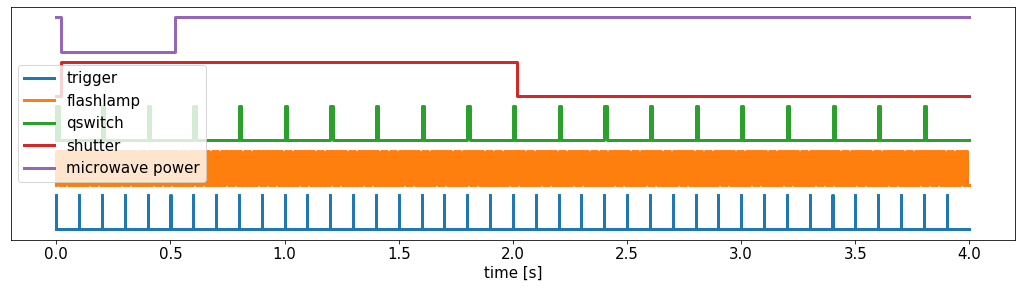

In [20]:
qswitch_delay = 145 # microseconds

trigger = {'frequency':10, 'offset':0, 'high': int(round(1e-4/1e-9,2)), 'channels':[0], 
           'active_high':True}
flashlamp = {'frequency':50, 'offset':0, 'high': int(round(10e-3/1e-9,2)), 'channels':[1], 
             'active_high':True}
qswitch = {'frequency':5, 'offset':int(round(qswitch_delay*1e-6/1e-9,2)), 'high':int(round(10e-3/1e-9,2)), 'channels':[2], 
           'active_high':True}
shutter = {'frequency': 5/20,'offset':int(round(20e-3/1e-9,2)), 'high':int(round(2/1e-9,2)), 'channels':[3], 
           'active_high':True}
microwave_power = {'frequency': 5/20,'offset':int(round(20e-3/1e-9,2)), 'high':int(round(5e-1/1e-9,2)), 'channels':[4], 
                   'active_high':False}
t, c, sequence = generate_repeating_pulses([trigger, flashlamp, qswitch, shutter, microwave_power], [])

# programmer = PulseSequenceProgrammer(0, sequence, {})
# programmer.program_device()
# pb_start()

# for s in sequence:
#     print(s)

channels = ['trigger', 'flashlamp', 'qswitch', 'shutter', 'microwave power'] 

tcum = np.cumsum(np.array(t)/1e9)
c = np.array(c)[:,:21]
select = np.where(np.sum(c, axis = 0) != 0)[0]
c = c[:,select]
# channels = None
if isinstance(channels, type(None)) or (len(channels) != len(select)):
    channels = ['CH '+str(i) for i in select]
fig, ax = plt.subplots(figsize = (18,18/21*len(select)))
for ids, s in enumerate(c.T):
    ax.step(tcum,s+1.3*ids, lw = 3)
ax.get_yaxis().set_ticks([])
ax.legend(channels, fontsize = 15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_size(15)

fig.savefig('pulse_cycle.png', dpi = 300)